# EDA

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sales = pd.read_csv('sales_train.csv')

In [40]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [41]:
sales[sales['item_id'] == 5822] # Playstation Plus 12-month subscription

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1350,03.01.2013,0,25,5822,999.0,1.0
1380,10.01.2013,0,25,5822,999.0,1.0
1381,13.01.2013,0,25,5822,999.0,2.0
1382,16.01.2013,0,25,5822,999.0,2.0
1383,21.01.2013,0,25,5822,999.0,1.0
...,...,...,...,...,...,...
2934312,15.10.2015,33,25,5822,1149.0,1.0
2934313,16.10.2015,33,25,5822,1149.0,1.0
2934314,20.10.2015,33,25,5822,1149.0,1.0
2934315,25.10.2015,33,25,5822,1149.0,1.0


In [42]:
from datetime import datetime
sales['date'] = sales['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))

In [43]:
df_ps_sales = sales[sales['item_id'] == 5822]

In [44]:
df_ps_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1350,2013-01-03,0,25,5822,999.0,1.0
1380,2013-01-10,0,25,5822,999.0,1.0
1381,2013-01-13,0,25,5822,999.0,2.0
1382,2013-01-16,0,25,5822,999.0,2.0
1383,2013-01-21,0,25,5822,999.0,1.0


In [45]:
df_ps_sales[df_ps_sales['item_cnt_day'] < 0] 
# Take only non-negative item_cnt_day
df_ps_sales = df_ps_sales[df_ps_sales['item_cnt_day'] >= 0]

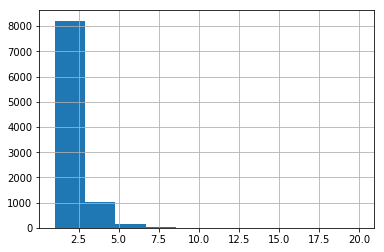

In [46]:
# Distribution of daily sales
df_ps_sales['item_cnt_day'].hist()

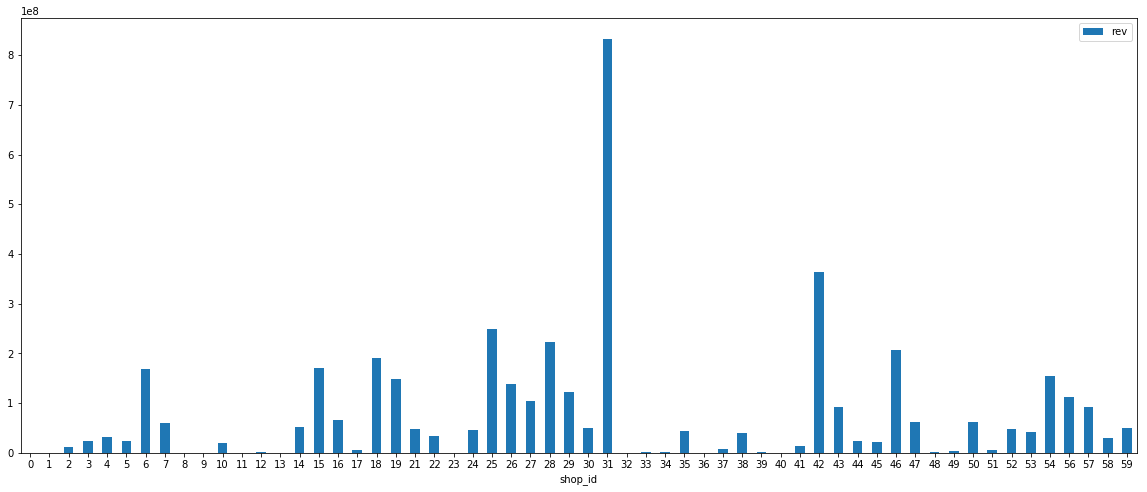

In [65]:
# Sales summmary per shop
df_summary_per_store = df_ps_sales.groupby('shop_id').agg({'item_price':'sum', 'item_cnt_day':'sum'})
df_summary_per_store['rev'] = df_summary_per_store['item_price'] * df_summary_per_store['item_cnt_day']
df_summary_per_store = df_summary_per_store.reset_index()
df_summary_per_store.plot.bar(x='shop_id', y='rev',rot=0,figsize=(20,8))

# Test Train Split & Ensemble Model Fit

In [99]:
df_ps_sales = df_ps_sales.sort_values('date',ignore_index=True)
train = df_ps_sales[df_ps_sales['date']<='2015-09-30']
test = df_ps_sales[df_ps_sales['date']>'2015-09-30']
train = train.drop('item_id',axis=1)
test = test.drop('item_id',axis=1)

train['day'] = train['date'].apply(lambda x: x.day)
train['month'] = train['date'].apply(lambda x: x.month)
train['year'] = train['date'].apply(lambda x: x.year)

test['day'] = test['date'].apply(lambda x: x.day)
test['month'] = test['date'].apply(lambda x: x.month)
test['year'] = test['date'].apply(lambda x: x.year)

In [100]:
train

,date,date_block_num,shop_id,item_price,item_cnt_day,day,month,year
0,2013-01-01,0,18,999.0,2.0,1,1,2013
1,2013-01-01,0,54,999.0,3.0,1,1,2013
2,2013-01-01,0,51,884.0,2.0,1,1,2013
3,2013-01-01,0,15,999.0,2.0,1,1,2013
4,2013-01-02,0,38,999.0,2.0,2,1,2013
...,...,...,...,...,...,...,...,...
9223,2015-09-29,32,31,1149.0,1.0,29,9,2015
9224,2015-09-30,32,50,1149.0,1.0,30,9,2015
9225,2015-09-30,32,14,1149.0,1.0,30,9,2015
9226,2015-09-30,32,42,1149.0,1.0,30,9,2015


In [105]:
X_train = train[['day', 'date_block_num','shop_id', 'item_price']]
y_train = train['item_cnt_day']
X_test = test[['day', 'date_block_num','shop_id', 'item_price']]
y_test = test['item_cnt_day']

In [114]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
pred = regr.predict(X_test).sum() # the sales for the specified month 
original = y_test.sum()

/Users/harutyungrigoryan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [115]:
print(pred, original)

271.5 259.0


In [117]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [118]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [119]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [122]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train,y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.8119 degrees.
Accuracy = 40.98%.


/Users/harutyungrigoryan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [123]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.6829 degrees.
Accuracy = 51.33%.


In [124]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 25.26%.


In [148]:
regr = RandomForestRegressor(n_estimators= 1600,min_samples_split= 2,min_samples_leaf= 4,max_features= 'sqrt',max_depth= 10,bootstrap= True)
regr.fit(X_train,y_train)
predRF = regr.predict(X_test).sum() # the sales for the specified month 
original = y_test.sum()

In [149]:
print(predRF,original)

273.9057040666332 259.0


# Stacking

In [213]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  

    def __init__(self, models, ens_model, modelNames, *args):
        """
        Initalization
        models - models for stacking
        ens_model - meta-model
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        self.modelNames = modelNames
        
#         self.X_train = None
#         self.y_train = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Fitting of Stacking
        p - how to split into test and train datasets, if p=0 all is train
        cv  (when p=0) - number of cv folds
        err (when p=0) - error rate
        random_state - generator initializer
            
        """
        if (p > 0): # test train split
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # fill the matrix for training
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # training metamodel
            self.ens_model.fit(self.valid, y_valid)
            
            
        else: # use all train
            
            # take err for regularization
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
       Stacking
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)
    
    
    def plot_model_results(self, X_test, y_test, X_train, y_train):
        res = {}
        original_value = y_test.sum()
        for model,modelName in zip(self.models,self.modelNames):
            model.fit(X_train, y_train)
            res[modelName] = abs(model.predict(X_test).sum() - original_value)

        res['Stacked'] = abs(self.predict(X_test).sum() - original_value)

        plt.figure(figsize=(12,6))
        plt.xlabel('Models')
        plt.ylabel('Abs Error')
        plt.bar(range(len(res)), list(res.values()), align='center')
        plt.xticks(range(len(res)), list(res.keys()))
        plt.show()

259.0123456133949


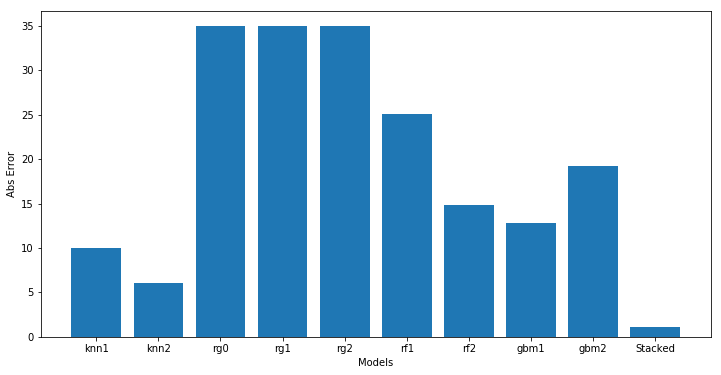

In [216]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

knn1 = KNeighborsRegressor(n_neighbors=3)
knn2 = KNeighborsRegressor(n_neighbors=10)

rg0 = Ridge(alpha=0.01)
rg1 = Ridge(alpha=1.1)
rg2 = Ridge(alpha=100.1)

rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
# obtained model
rf2 = RandomForestRegressor(n_estimators= 1600,min_samples_split= 2,min_samples_leaf= 4,max_features= 'sqrt',max_depth= 10,bootstrap= True)

gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=2, n_estimators=200, nthread=-1, objective='regression')    
gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=5, n_estimators=200, nthread=-1, objective='regression')    

models = [knn1, knn2, rg0, rg1, rg2, rf1, rf2, gbm1, gbm2]
modelNames = ['knn1', 'knn2', 'rg0', 'rg1', 'rg2', 'rf1', 'rf2', 'gbm1', 'gbm2']

ens_model = Ridge()
stacking_model=DjStacking(models, ens_model, modelNames)
stacking_model.fit(X_train,y_train, p=0)
predStacking = stacking_model.predict(X_test).sum()
print(stacking_model.predict(X_test).sum())
stacking_model.plot_model_results(X_test, y_test, X_train, y_train)